<a href="https://colab.research.google.com/github/nityamshah/datascience/blob/main/NityShahU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# The Data Set

In this model, I'm creating a hierarchal model to model TRB (total rebounds) by player position using a basketball data set with stats on 573 players. A snapshot of the data can be seen below.

In [ ]:
# importing basketball data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv"
# making position a categorical variable so that we can group by position
data = pd.read_csv(url,dtype={'Pos':'category'})

# keeping only the relevant columns
data = data[['Player', 'Pos', 'TRB']]
data

,Player,Pos,TRB
0,Precious Achiuwa,PF-C,487
1,Bam Adebayo,C,737
2,Ochai Agbaji,SG,216
3,Santi Aldama,PF,352
4,Nickeil Alexander-Walker,SG,167
...,...,...,...
567,Thaddeus Young,PF,103
568,Trae Young,PG,149
569,Omer Yurtseven,C,208
570,Cody Zeller,C,112


In [ ]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = data.Pos.cat.codes.values

#an array of the strings that represent positions
pos_codes = data.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bask_coords = {"pos": pos_codes}

# The Model

If we visualize the data in a violin plot, it looks like this. At first glance, it appears to be skewed right (positive skew). This informed my first shot at the model. I made a hierarchal model with SkewNormal.

<Axes: ylabel='TRB'>

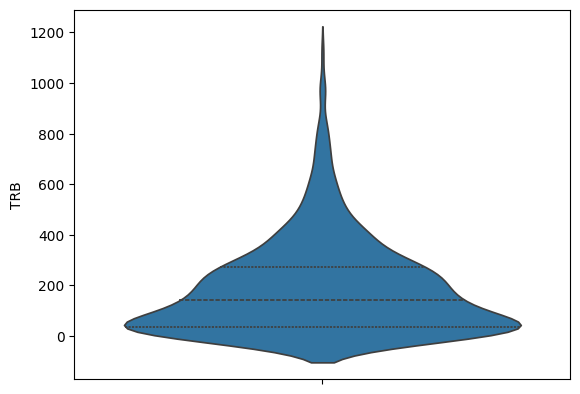

In [ ]:
# visualizing data
sns.violinplot(data.TRB,inner='quart')

This is the Skew Normal model without having separated by position yet. I just wanted to see if the model lined up well. It had some divergences but still ran. However, plotting my posterior predictive check showed that it didn't line up too well and maybe an exponential model would be a better fit.

In [ ]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 300)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 30)

    #priors
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd)

    σ = pm.HalfNormal('σ', sigma = 10)

    α = pm.Exponential('α', lam = 5)

    #skewnormal
    _ = pm.SkewNormal('trb', mu = μ, sigma = σ, alpha = α, observed = data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='trb'>

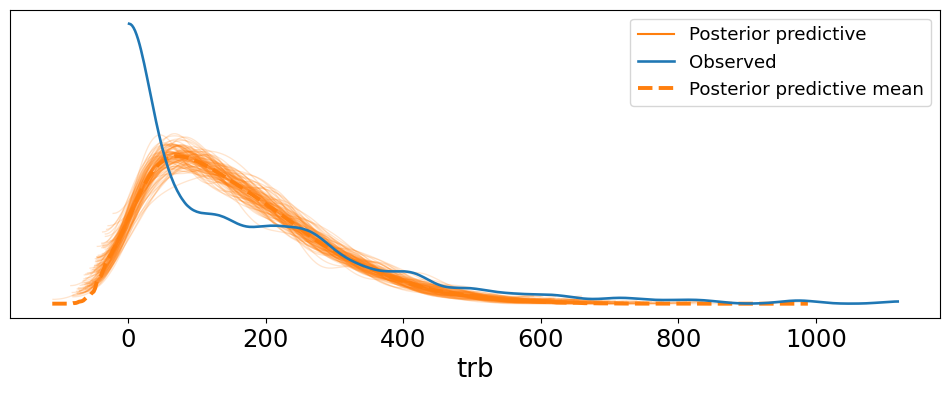

In [ ]:
pm.sample_posterior_predictive(idata_bask, model=bask_model, extend_inferencedata=True)
az.plot_ppc(idata_bask, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

After looking at the Skew Normal model, I could see that the observed data actually better fits an exponential model so I wanted to try that. It's shown below. At this point, I still have not grouped by position. This model had 0 divergences and fit much better than the Skew Normal.

In [ ]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b)

    #exponential
    _ = pm.Exponential('trb', lam = λ, observed = data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to have divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

Output()

(0.0, 1100.0)

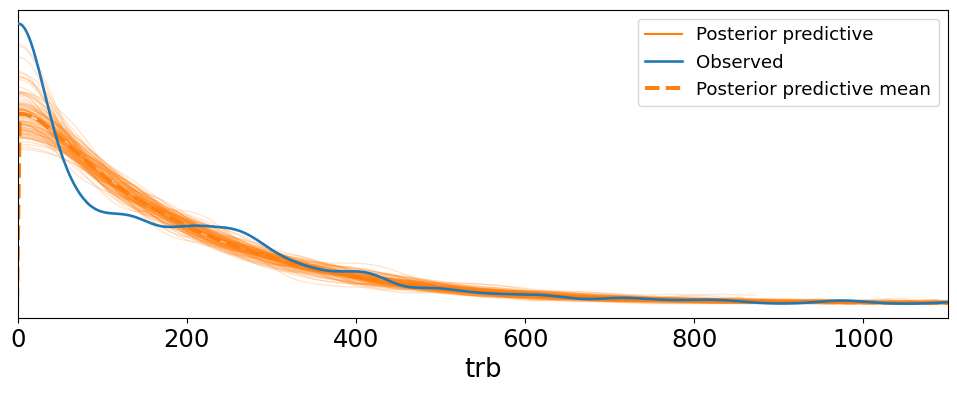

In [ ]:
pm.sample_posterior_predictive(idata_bask, model=bask_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_bask, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 1100)

Now that the model was a better fit, I separated the posterior by position so that there's a different prior for each but all of them have common hyperpriors. This also had 0 divergences.

In [ ]:
with pm.Model(coords = bask_coords) as bask_model:
    #hyperpriors
    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)

    #priors
    λ = pm.Gamma('λ', alpha = a, beta = b, dims = "pos")

    #exponential
    _ = pm.Exponential('trb', lam = λ[pos_idx], observed = data.TRB.values)

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

# Analysis

When I create trace plots for the parameters of the inference data object, I had to limit the λ x axis to make it more readable. These trace plots can be seen below for the exponential model separated by position. In the λ plot, you can see that some positions have clear peaks while others are much flatter and spread. We'll see this again with the forest plot.

(0.0, 0.015)

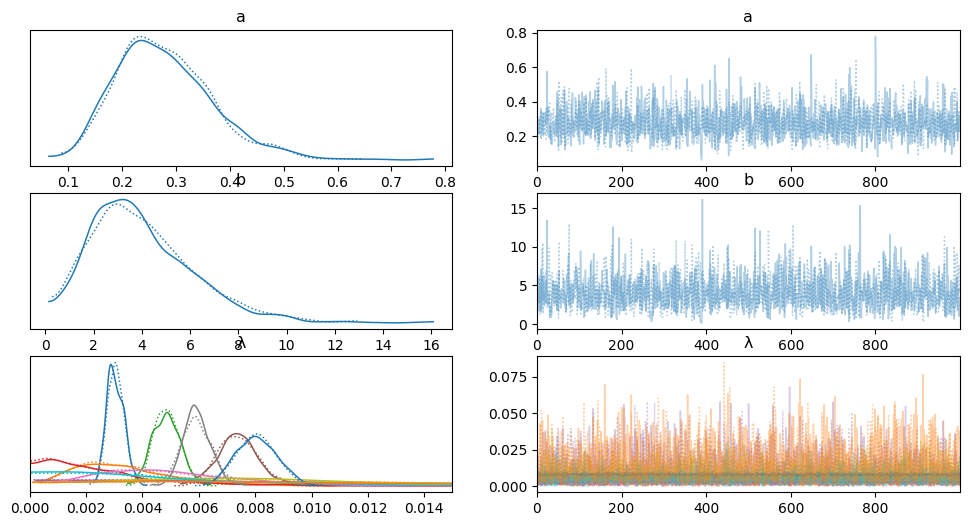

In [ ]:
#az.plot_trace(idata_bask) but limiting the graph of the λ so it is easier to read
az.plot_trace(idata_bask)[2,0].set_xlim([0, .015])

Below, you can see rhat values that are close to ideal.

In [ ]:
az.rhat(idata_bask) #ideally between 1 and 1.001. values above 1.1 are bad

<xarray.Dataset> Size: 352B
Dimensions:  (pos: 12)
Coordinates:
  * pos      (pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    a        float64 8B 1.001
    b        float64 8B 1.001
    λ        (pos) float64 96B 1.002 1.001 1.001 0.9994 ... 1.0 1.004 1.0 1.002

Finally, here's the forest plot of the λ by position, but we will have to take the reciprocal of this to get the actual prediction.

array([<Axes: >], dtype=object)

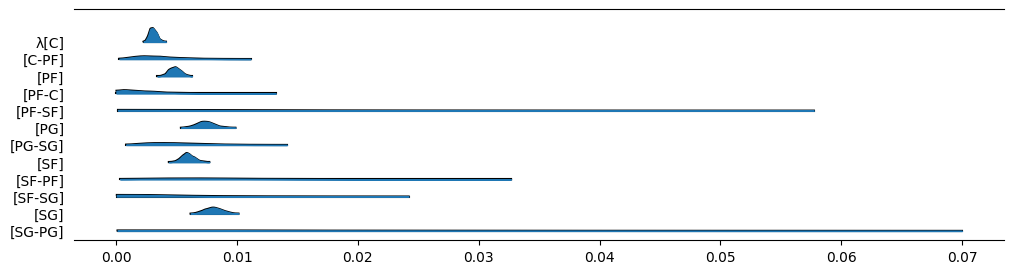

In [ ]:
az.plot_forest(idata_bask, var_names=['λ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

In the code below, I take the means of the lamda variable by position and then takes the reciprocal of each one.

In [ ]:
#retrieving the array of means

posterior = idata_bask.posterior
lambda_variable = posterior['λ']
mean_lambda = lambda_variable.mean(dim=['chain', 'draw'])
mean_array = mean_lambda.values

#print(mean_array)

#creating the array of reciprocals

reciprocal_array = []
for value in mean_array:
    reciprocal = 1 / value
    reciprocal_array.append(reciprocal)

#print (reciprocal_array)

# go through each of the positions and print it next to the 1/lamda
# print(pos_codes)
for i in range(len(pos_codes)):
    position = pos_codes[i]
    reciprocal = reciprocal_array[i]
    print(f'{position}: {reciprocal}')

C: 327.19313347948
C-PF: 293.85424315971386
PF: 205.97276917676834
PF-C: 384.02008844276855
PF-SF: 87.18300495988264
PG: 135.3087618762906
PG-SG: 199.07553249109037
SF: 168.5641208229511
SF-PF: 109.47481540118615
SF-SG: 212.81607468699949
SG: 124.26501469966296
SG-PG: 64.21368039657163


Here, it's visualized in a bar graph.

<BarContainer object of 12 artists>

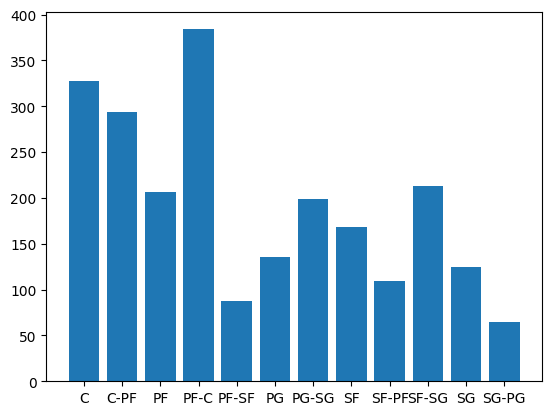

In [ ]:
plt.bar(pos_codes, reciprocal_array)

# Conclusion

The positions stand for:


C: Center

PF: Power Forward

SF: Small Forward

PG: Point Guard

SG: Shooting Guard



In basketball, Centers and Power Forwards will probably grab the most rebounds because their roles as dominant players close to the net so we can expect to see higher predicted TRB values for C, PF, C-PF and PF-C. This lines up with what we see in the bar graph above. The guards will likely have less because they usually handle the ball and set up plays. This also matches with what we see.

This is a good sign that the model is working well.